# Preparacion del entorno

Librerias

In [1]:
import tensorflow as tf
from tensorflow import keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from keras import Sequential
from keras import losses, metrics, optimizers
from keras.applications import mobilenet
from keras.layers import Input, Dense, Conv2D, Flatten, LeakyReLU, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Reshape

import ipynb.fs     #Para importar desde ipynb
import numpy as np
import matplotlib.pyplot as plt
import os

Num GPUs Available:  1


# Preparacion de los datos

In [2]:
from .defs.preparacion_datos import unpickle, tryDataset

(50000, 32, 32, 3)


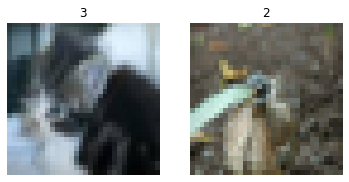

(10000, 32, 32, 3)


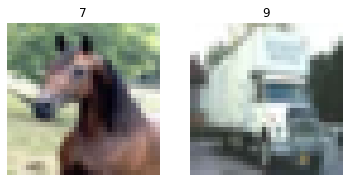

In [3]:
X_train = unpickle("Input\cifar-10-train")
X_test = unpickle("Input\cifar-10-test")
tryDataset(X_train)
tryDataset(X_test)

# Arquitectura del ``Autoencoder``

In [4]:
from .defs.arquitectura import *

# Entrenamiento

## Persistencia

In [5]:
_raiz = "Resultados/pruebasAAE"
_nombre = "pAAE"

Creamos las carpetas para almacenar el output

In [6]:
def mkfolders(ruta, verbose=False):
    try:
        os.makedirs(ruta)
    except OSError:
        if verbose: print("Carpeta %s ya existe" % (ruta))
    

In [7]:
mkfolders(_raiz, True)

Carpeta Resultados/pruebasAAE ya existe


## Funciones de muestreo

In [8]:
def sample_imgs(dataset, model, epoch, sample_size=5, save_imgs=True, show=False, ruta=_raiz, nombre="", title=""):
    # Tomamos sample_size imagenes de muestra
    ids = np.random.randint(0,dataset.shape[0], sample_size)
    sample=dataset[ids]
    # Intentamos regenerar las imagenes
    gen_img = model.predict(sample)[0]
    # Guardamos una grafica con la muestra (arriba) y las imagenes generadas (abajo)
    f, axxs = plt.subplots(2,sample_size)
    if title!="":
        f.suptitle(title+"_"+nombre, fontsize=12)
    for j in range(sample_size):
        axxs[0,j].imshow(sample[j])
        axxs[1,j].imshow(gen_img[j])
    for i in axxs:
        for j in i:
            j.axis("off")
    if save_imgs:
        ruta+="/Output/Regeneracion"
        mkfolders(ruta)
        savefile= ruta+"/"+nombre+"generationCIFAR10_e%d.jpg" % (epoch)
        f.savefig(savefile)
    if show:
        plt.show()
    plt.close()
    

In [9]:
def true_sampler(dim_latente, batch_size):
    return np.random.normal(size=(batch_size, dim_latente))

In [10]:
def generate_samples(dim_latente, decoder, epoch, ruta=_raiz, nombre=_nombre, output=True, show=False):
    sample_shape = (5,5)
    latent_samples = true_sampler(dim_latente, np.prod(sample_shape))
    samples=decoder.predict(latent_samples)#*0.5 +0.5
    fig, axxs = plt.subplots(sample_shape[0], sample_shape[1])
    s=0
    for i in range(sample_shape[0]):
        for j in range(sample_shape[1]):
            axxs[i,j].imshow(samples[s])
            axxs[i,j].axis("off")
            s+=1
    if output:
        ruta+="/Output/Progreso"
        mkfolders(ruta)
    fig.savefig(ruta+"\\"+nombre+"progresscifar10_e%d.png" % (epoch))
    if show:
        print("Imagenes generadas desde el espacio latente:")
        plt.show()
    plt.close()

    

In [11]:
from IPython.display import Image
from IPython.display import display
def show_prevResults(ruta, nombre=_nombre, epochs=5000):
    
    x = Image(filename=ruta+'\\Output/Progreso'+"\\"+nombre+"progresscifar10_e%d.png" % (epochs-1))
    print("Imagenes generadas desde el espacio latente:")
    display(x)

    x = Image(filename=ruta+"\\"+nombre+"progresscifar10_plot.jpg")
    print("Historia del entrenamiento:")
    display(x)

    x = Image(filename=ruta+"/Output/Regeneracion/TRAINSETgenerationCIFAR10_e%d.jpg" % (epochs))
    print("Imagenes regeneradas desde el set de entrenamiento (arriba originales):") 
    display(x) 
     
    x = Image(filename=ruta+"/Output/Regeneracion/TESTSETgenerationCIFAR10_e%d.jpg" % (epochs))         
    print("Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):")
    display(x)

    n = np.random.randint(0, 10)
    x = Image(filename=ruta+"/Output/Latente/GenFromLatentTRAINSET label %d.jpg" % (n))         
    print("Imagenes generadas desde el punto medio entre coordenadas latentes de dos imagenes (TrainSet):")
    display(x)
    
    x = Image(filename=ruta+"/Output/Latente/GenFromLatentTESTSET label %d.jpg" % (n))         
    print("Imagenes generadas desde el punto medio entre coordenadas latentes de dos imagenes (TestSet):")
    display(x)
    

In [12]:
def exploraLatente(encoder, decoder, groupPath, ruta=_raiz, nombre=_nombre):
    groups = unpickle(groupPath)
    ruta+="/Output/Latente"
    mkfolders(ruta)
    for key in groups.keys():
        imgs = groups[key]
        latent = []
        size = len(imgs)
        # Obtencion de coordenadas en espacio latente
        #for i in range(size):
        pred = encoder.predict(imgs)
        latent = pred
            #latent.append(pred)
        # Obtenemos la coordenada intermedia
        latent = tf.math.divide(tf.math.add_n(latent),size)
        latent = np.array([latent])
        #Generamos la imagen de esa coordenada
        generated = decoder.predict(latent)

        f, axxs = plt.subplots(1,size+1)
        f.suptitle("Latent aproximation for class "+str(key)+" from " + groupPath, fontsize=12)
        for j in range(size):
            axxs[j].imshow(imgs[j])
            axxs[j].axis("off")
            axxs[j].set_title("Real")
        axxs[size].imshow(generated[0])
        axxs[size].axis("off")
        axxs[size].set_title("Generated")
        plt.show()
        plt.close()
        
        f.savefig(ruta+"\\"+nombre+" label %d.jpg" % (key))

## Grafica de progreso

In [13]:
def plot_history(history, ruta=_raiz, nombre=_nombre, title=""):
    disc_loss = history[0]
    disc_acc  = history[1]
    aac_loss1 = history[2]
    aac_loss2 = history[3]

    fig, axxs = plt.subplots(1,3)
    if title != "":
        fig.suptitle(title, fontsize=16)

    fig.set_figwidth(24)
    fig.set_figheight(6)

    axxs[0].set_title("Discriminator")
    axxs[1].set_title("Discriminator")
    axxs[2].set_title("AdversarialAutoencoder")

    axxs[0].set_xlabel("Epoch")
    axxs[1].set_xlabel("Epoch")
    axxs[2].set_xlabel("Epoch")

    axxs[0].plot(disc_loss, label = "Loss")
    axxs[1].plot(disc_acc, label = "Accuracy")

    axxs[2].plot(aac_loss1, label = "Loss_decoder")
    axxs[2].plot(aac_loss2, label = "Loss_discriminator")

    axxs[0].legend()
    axxs[1].legend()
    axxs[2].legend()

    fig.savefig(ruta+"\\"+nombre+"progresscifar10_plot.jpg")
    plt.show()
    plt.close()

## Funcion de entrenamiento

In [14]:
def fit_AAE(dim_latente, aae, epochs=12, batch_size=100, sample_interval=100, ruta=_raiz, nombre=_nombre, verbose=True):
    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    dataset = dataset.shuffle(50000, seed=2022)
    dataset = dataset.batch(batch_size)

    history = np.empty([0,4])

    encoder, decoder, discriminator, a_autoencoder=aae
    
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        print("EPOCH %d" % (epoch))
        for step, imgs in enumerate(dataset):
            #Espacios latentes "reales" y "falsos" para el discriminador
            latent_fake = encoder.predict(imgs)
            latent_true = true_sampler(dim_latente, batch_size)

            #entrenamos el discriminador
            dis_loss_real = discriminator.train_on_batch(latent_true, valid)
            dis_loss_fake = discriminator.train_on_batch(latent_fake, fake)
            dis_avg_loss = 0.5*np.add(dis_loss_fake, dis_loss_real)

            # entrenamos al autoencoder
            aae_loss = a_autoencoder.train_on_batch(imgs,[imgs, valid])
            
            # Guardamos el progreso
            history = np.append(history, [np.append(dis_avg_loss[:2], aae_loss[:2])], axis=0)
            
            # monitorizamos el progreso
            if ((step+1) % sample_interval)==0 and verbose:
                print("Epoch: %d Step: %d Disc: (loss = %f, acc = %.2f%%) AAE: (mse = %f, b_ce = %f)" % (epoch, step, dis_avg_loss[0], 100*dis_avg_loss[1], aae_loss[0], aae_loss[1]))
            # Hacemos una muestra visual
        generate_samples(dim_latente, decoder, epoch, ruta=ruta, nombre=nombre, show=((epoch+1)==epochs))
    return history.transpose(1,0)

## Entrenamiento en grid

In [15]:
# Temporal
X_train = X_train["data"]
sample_from = X_test["data"]

Tamaño de la capa latente:

In [16]:
dim_latente_cand = [64, 128, 256, 512, 1024]

Tamaño de las imagenes:

In [17]:
img_shape = X_train[0].shape

Parametros:

In [18]:
encoders = [(build_dense_encoder, "dense_enc"), (build_transf_encoder,"transf_enc"), (build_conv_encoder,"conv_enc")]
decoders = [(build_dense_decoder,"dense_dec"), (build_conv_decoder,"conv_dec")]
discriminators = [(build_discriminator ,"default_disc")]
ae_losses = [(losses.mean_squared_error, "ae_MSE_loss")]
disc_losses =[(losses.binary_crossentropy, "disc_binXentropy_loss")]

In [19]:
dim_latente_cand = [64,128]                         # para que las pruebas no tarden 2 horas
#dim_latente_cand = [64, 256, 1024]              # para que las pruebas no tarden 7 horas
#decoders = [(build_dense_decoder,"dense_dec")]  # para que las pruebas no tarden 2 horas

In [20]:
epochs = 12

In [21]:
def mainLoop(model_name="MODEL", enc= (build_dense_encoder, "dense_enc"), dec = (build_dense_decoder,"dense_dec")):
    for ae_loss in ae_losses:
        for disc in discriminators:
            for disc_loss in disc_losses:
                for dim_latente in dim_latente_cand:
                    ruta = _raiz+"\\"+model_name+"\\"+ae_loss[1]+"\\"+disc[1]+"\\"+disc_loss[1]+"\\"+str(dim_latente)
                    if os.path.isfile(ruta+"/Modelos\\decoder.h5") or os.path.isfile(ruta+"/Modelos\\autoencoder.h5"):
                        print(ruta+" ya ha sido entrenada")
                        show_prevResults(ruta, epochs=epochs)
                        continue
                    mkfolders(ruta, True)
                    ck = {"ae_loss": ae_loss[0], "disc_loss":disc_loss[0]}
                    aae = assemble_AAE(dim_latente, img_shape, enc_model = enc[0], dec_model = dec[0], disc_model = disc[0], 
                                    compilation_kwargs=ck)
                    history = fit_AAE(dim_latente, aae, epochs=epochs, ruta = ruta)
                    print("Historia del entrenamiento:")
                    plot_history(history, ruta=ruta, title=ruta)
                    (encoder, decoder, _, autoencoder) = aae
                    print("Imagenes regeneradas desde el set de entrenamiento (arriba originales):")
                    sample_imgs(X_train, autoencoder, epoch=epochs, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TRAINSET")
                    print("Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):")
                    sample_imgs(sample_from, autoencoder, epoch=epochs, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TESTSET")
                    print("Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):")
                    exploraLatente(encoder, decoder, "Input\cifar-10-groupedtrain", ruta=ruta, nombre="GenFromLatentTRAINSET")
                    print("Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):")
                    exploraLatente(encoder, decoder, "Input\cifar-10-groupedtest", ruta=ruta, nombre="GenFromLatentTESTSET")
                    mkfolders(ruta+"/Modelos")
                    decoder.save(ruta+"/Modelos\\decoder.h5")
                    autoencoder.save(ruta+"/Modelos\\autoencoder.h5")


### Entrenamiento de AAE Denso

Resultados/pruebasAAE\DENSE\ae_MSE_loss\default_disc\disc_binXentropy_loss\64 ya ha sido entrenada
Imagenes generadas desde el espacio latente:


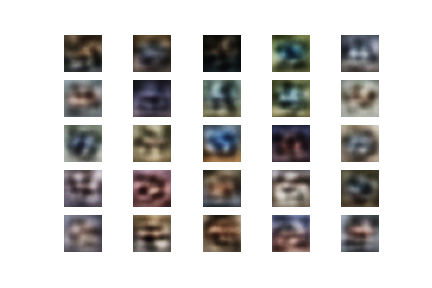

Historia del entrenamiento:


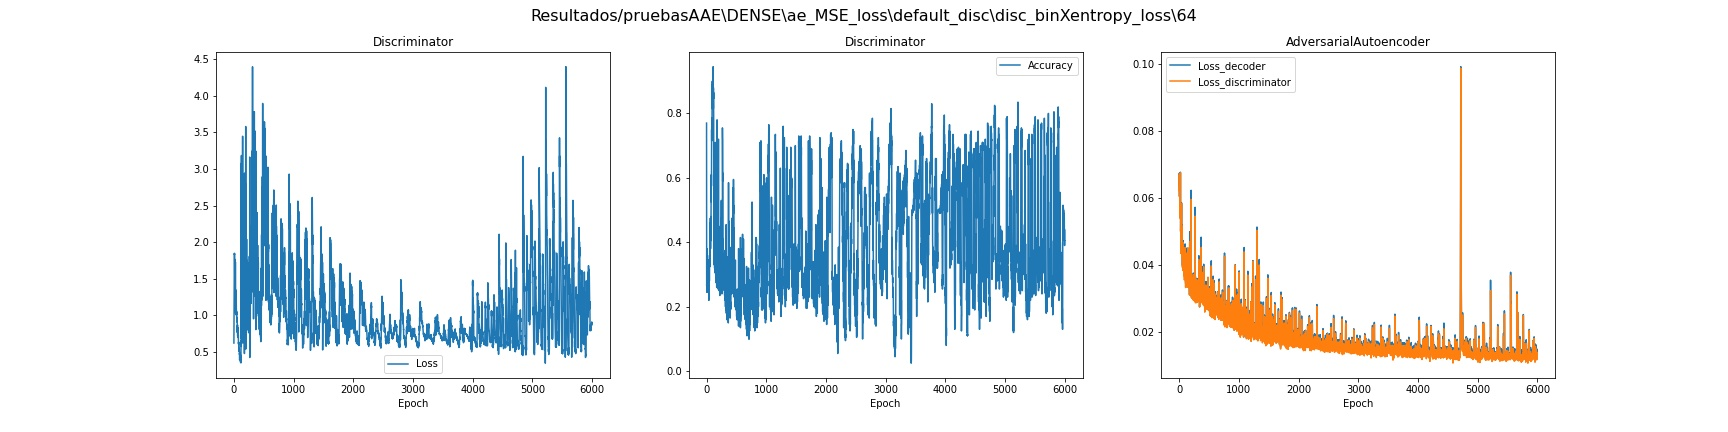

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


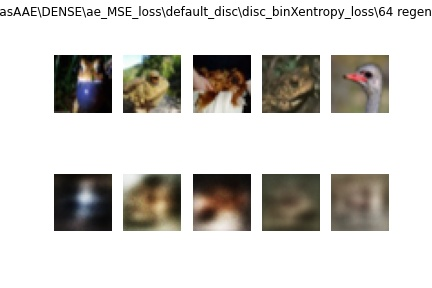

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


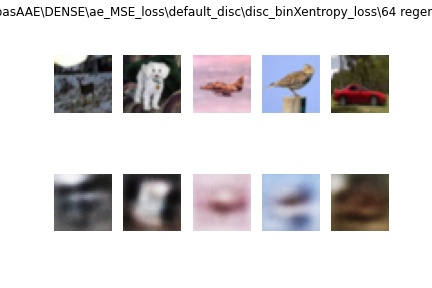

Imagenes generadas desde el punto medio entre coordenadas latentes de dos imagenes (TrainSet):


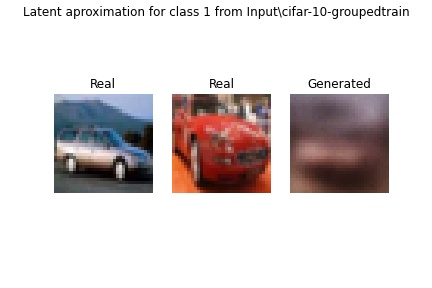

Imagenes generadas desde el punto medio entre coordenadas latentes de dos imagenes (TestSet):


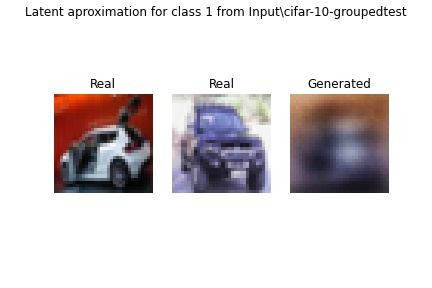

Layers for input 128 and output 1:
Layer 1: 25 neurons
Layer 2: 5 neurons
Layers for input 3072 and output 128:
Layer 1: 1065 neurons
Layer 2: 369 neurons
Layers for input 128 and output 3072:
Layer 1: 369 neurons
Layer 2: 1065 neurons
EPOCH 0
Epoch: 0 Step: 99 Disc: (loss = 1.244557, acc = 39.50%) AAE: (mse = 0.044864, b_ce = 0.044599)
Epoch: 0 Step: 199 Disc: (loss = 0.491921, acc = 78.50%) AAE: (mse = 0.037431, b_ce = 0.036102)
Epoch: 0 Step: 299 Disc: (loss = 0.798907, acc = 39.50%) AAE: (mse = 0.030072, b_ce = 0.029404)
Epoch: 0 Step: 399 Disc: (loss = 1.067761, acc = 39.50%) AAE: (mse = 0.028804, b_ce = 0.028334)
Epoch: 0 Step: 499 Disc: (loss = 0.627086, acc = 64.00%) AAE: (mse = 0.026128, b_ce = 0.025017)
EPOCH 1
Epoch: 1 Step: 99 Disc: (loss = 0.776293, acc = 50.00%) AAE: (mse = 0.031880, b_ce = 0.030764)
Epoch: 1 Step: 199 Disc: (loss = 1.288213, acc = 33.50%) AAE: (mse = 0.026961, b_ce = 0.026361)
Epoch: 1 Step: 299 Disc: (loss = 0.881002, acc = 41.00%) AAE: (mse = 0.023346,

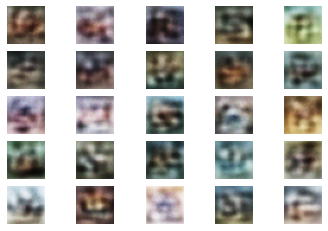

Historia del entrenamiento:


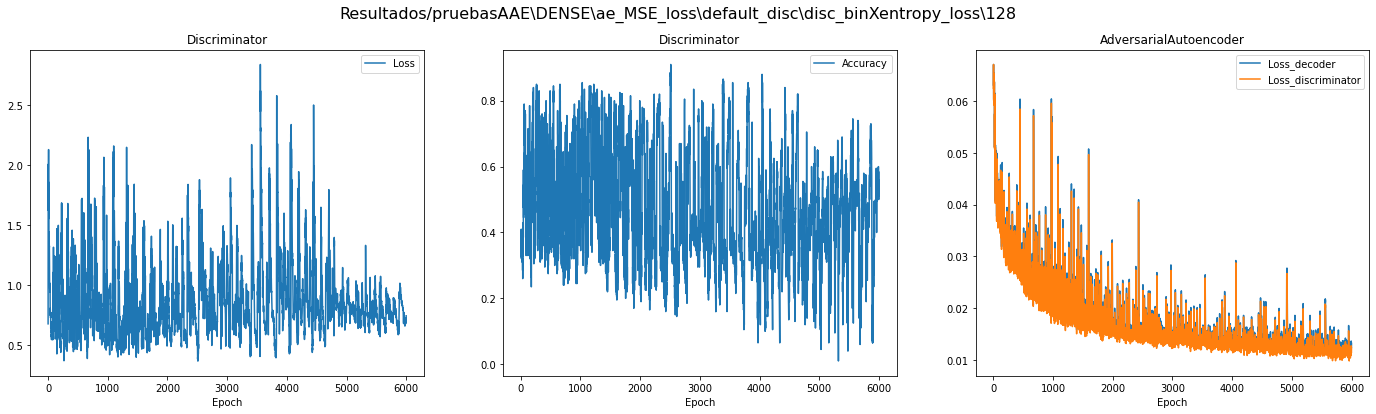

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


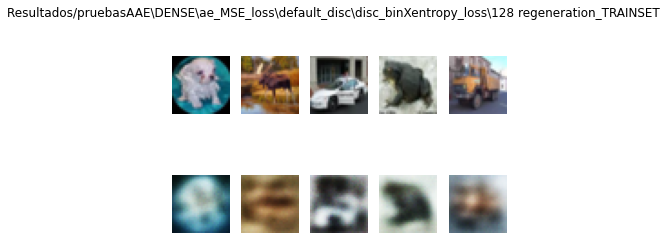

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


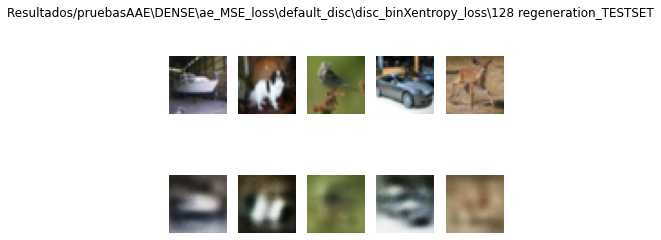

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):


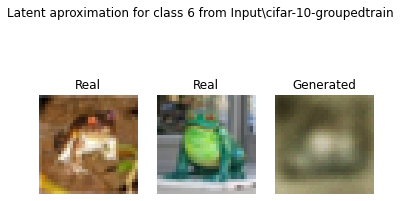

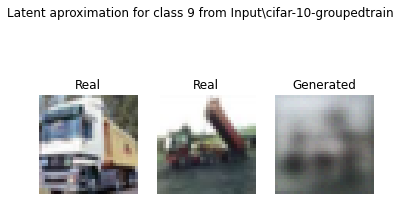

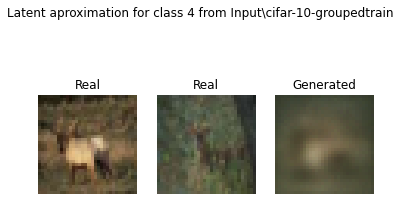

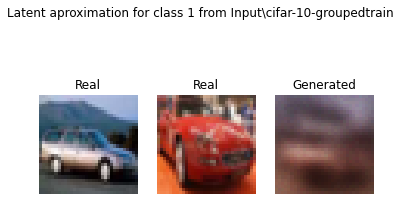

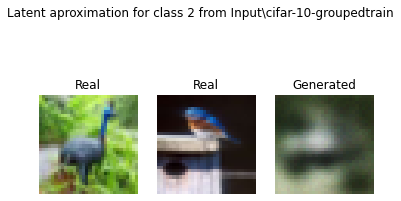

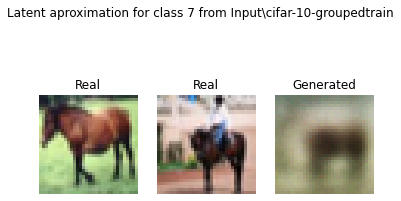

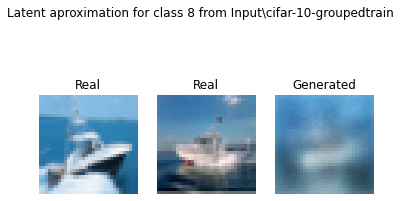

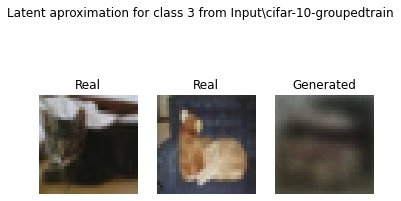

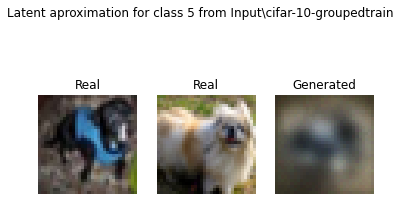

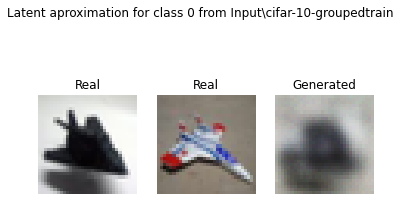

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):


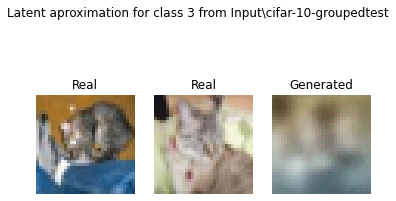

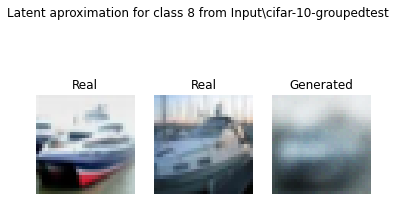

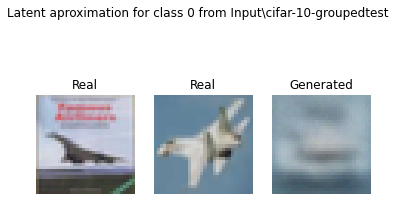

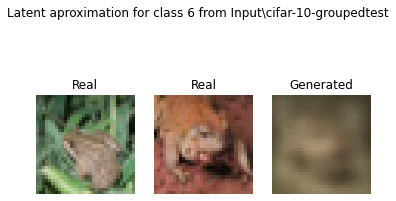

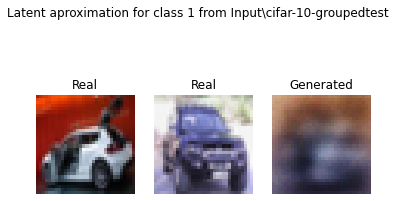

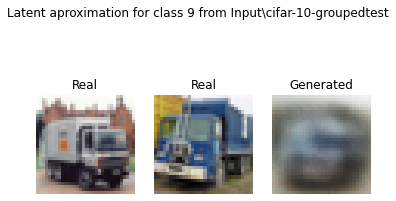

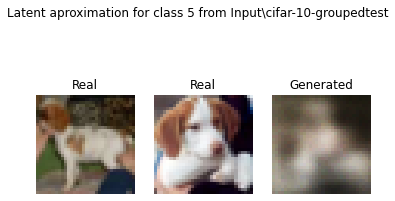

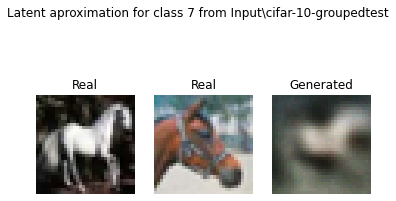

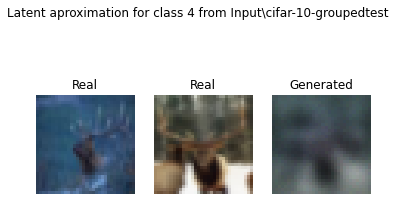

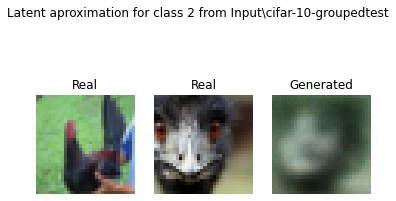

In [22]:
enc = (build_dense_encoder, "dense_enc")
dec = (build_dense_decoder,"dense_dec")
model_name = "DENSE"

mainLoop(enc=enc, dec=dec, model_name=model_name)


### Entrenamiento de AAE Convolucional

Layers for input 64 and output 1:
Layer 1: 16 neurons
Layer 2: 4 neurons
EPOCH 0
Epoch: 0 Step: 99 Disc: (loss = 0.528967, acc = 84.50%) AAE: (mse = 0.030262, b_ce = 0.029269)
Epoch: 0 Step: 199 Disc: (loss = 0.325894, acc = 92.50%) AAE: (mse = 0.022081, b_ce = 0.020649)
Epoch: 0 Step: 299 Disc: (loss = 0.596394, acc = 71.00%) AAE: (mse = 0.018464, b_ce = 0.017478)
Epoch: 0 Step: 399 Disc: (loss = 0.253545, acc = 90.50%) AAE: (mse = 0.019889, b_ce = 0.018088)
Epoch: 0 Step: 499 Disc: (loss = 0.346253, acc = 90.00%) AAE: (mse = 0.017087, b_ce = 0.015972)
EPOCH 1
Epoch: 1 Step: 99 Disc: (loss = 1.081952, acc = 44.00%) AAE: (mse = 0.015917, b_ce = 0.015438)
Epoch: 1 Step: 199 Disc: (loss = 1.027766, acc = 47.00%) AAE: (mse = 0.017929, b_ce = 0.017386)
Epoch: 1 Step: 299 Disc: (loss = 1.819273, acc = 35.50%) AAE: (mse = 0.015502, b_ce = 0.015286)
Epoch: 1 Step: 399 Disc: (loss = 1.377387, acc = 35.00%) AAE: (mse = 0.016933, b_ce = 0.016653)
Epoch: 1 Step: 499 Disc: (loss = 1.286777, acc = 

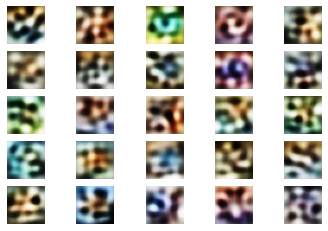

Historia del entrenamiento:


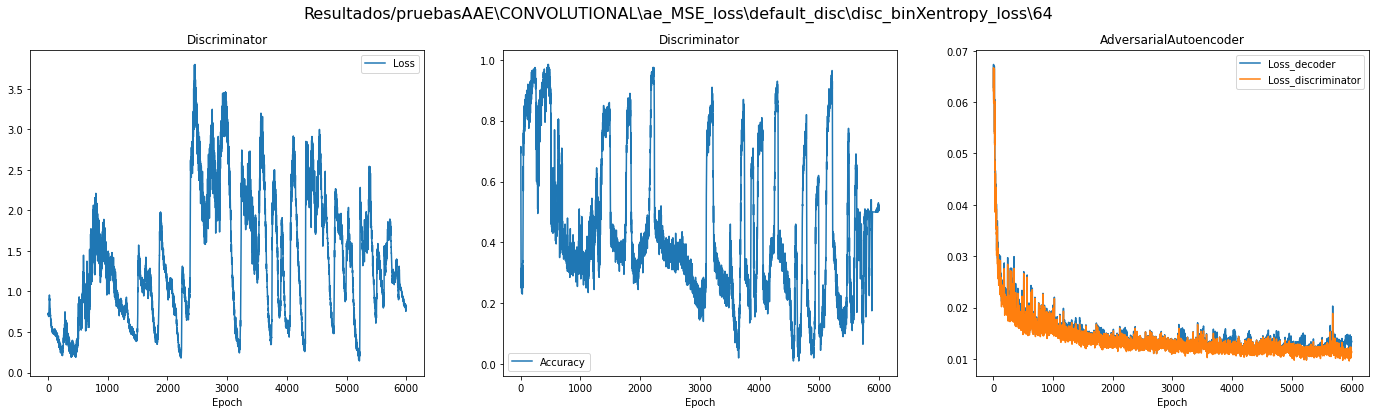

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


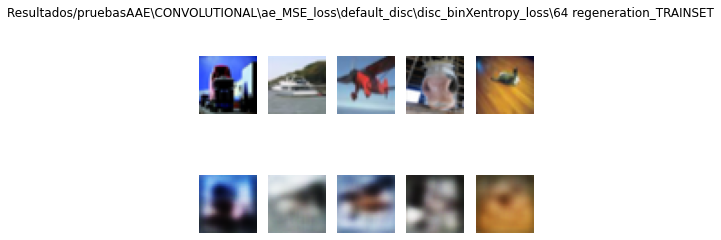

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


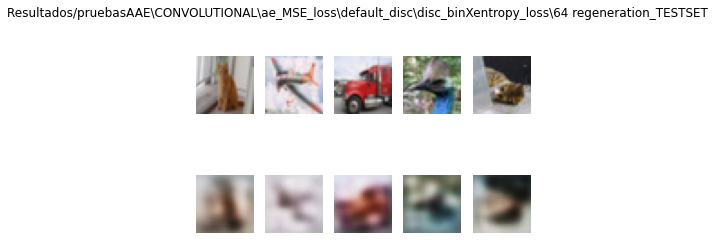

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):


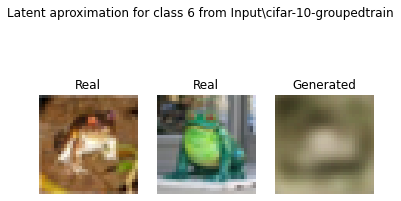

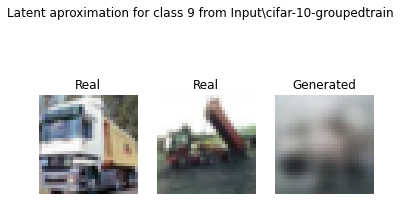

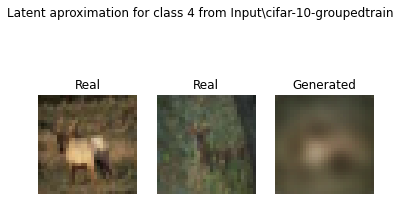

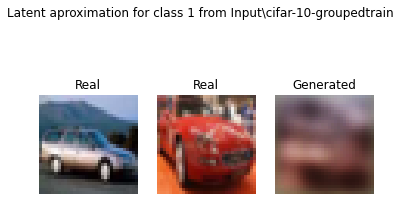

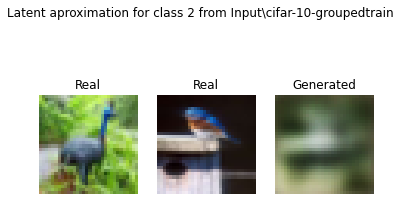

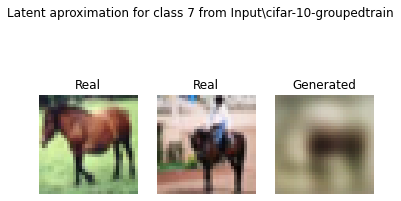

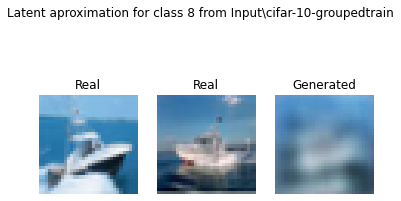

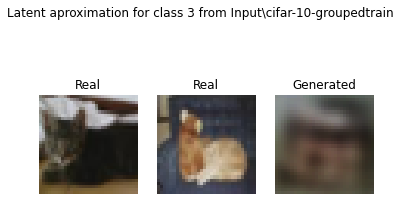

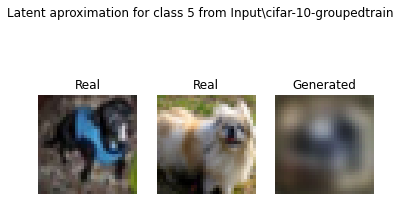

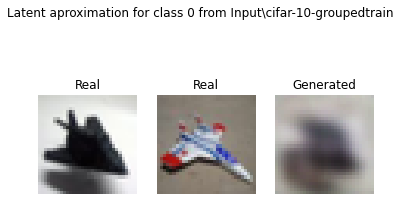

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):


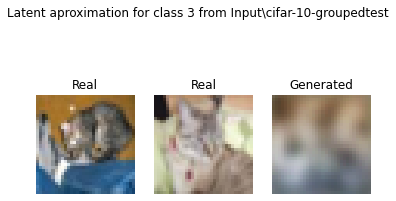

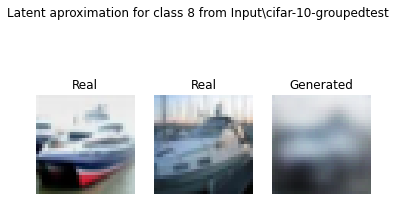

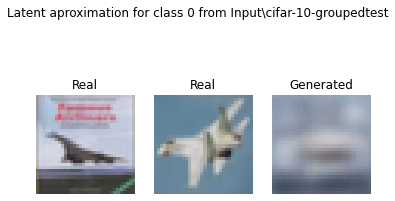

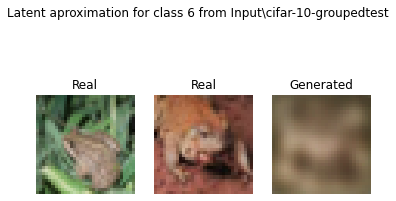

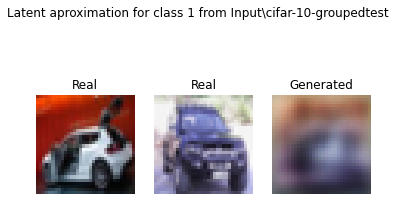

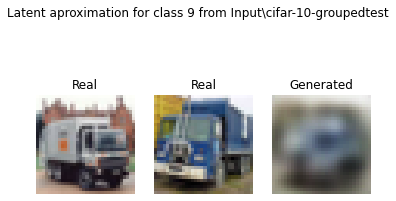

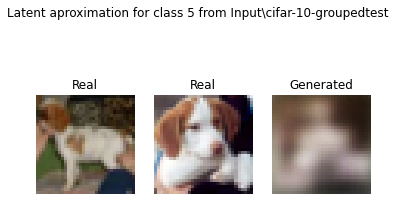

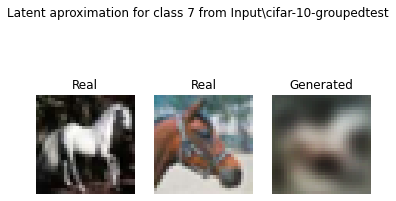

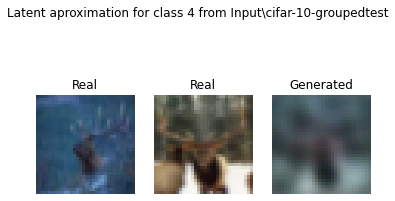

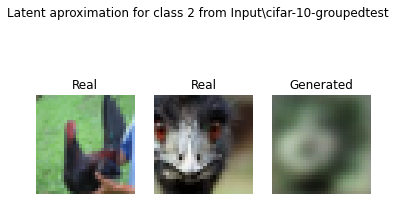

Layers for input 128 and output 1:
Layer 1: 25 neurons
Layer 2: 5 neurons
EPOCH 0
Epoch: 0 Step: 99 Disc: (loss = 0.644373, acc = 59.00%) AAE: (mse = 0.029476, b_ce = 0.028774)
Epoch: 0 Step: 199 Disc: (loss = 0.347829, acc = 95.50%) AAE: (mse = 0.021220, b_ce = 0.019653)
Epoch: 0 Step: 299 Disc: (loss = 0.279720, acc = 95.00%) AAE: (mse = 0.017701, b_ce = 0.016172)
Epoch: 0 Step: 399 Disc: (loss = 0.220818, acc = 96.50%) AAE: (mse = 0.017972, b_ce = 0.016197)
Epoch: 0 Step: 499 Disc: (loss = 0.574234, acc = 65.00%) AAE: (mse = 0.015218, b_ce = 0.014293)
EPOCH 1
Epoch: 1 Step: 99 Disc: (loss = 0.673173, acc = 72.00%) AAE: (mse = 0.015703, b_ce = 0.014452)
Epoch: 1 Step: 199 Disc: (loss = 1.073368, acc = 57.00%) AAE: (mse = 0.018217, b_ce = 0.017208)
Epoch: 1 Step: 299 Disc: (loss = 1.213334, acc = 39.00%) AAE: (mse = 0.014344, b_ce = 0.013870)
Epoch: 1 Step: 399 Disc: (loss = 1.045161, acc = 35.00%) AAE: (mse = 0.016063, b_ce = 0.015498)
Epoch: 1 Step: 499 Disc: (loss = 0.714316, acc =

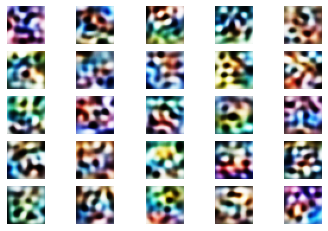

Historia del entrenamiento:


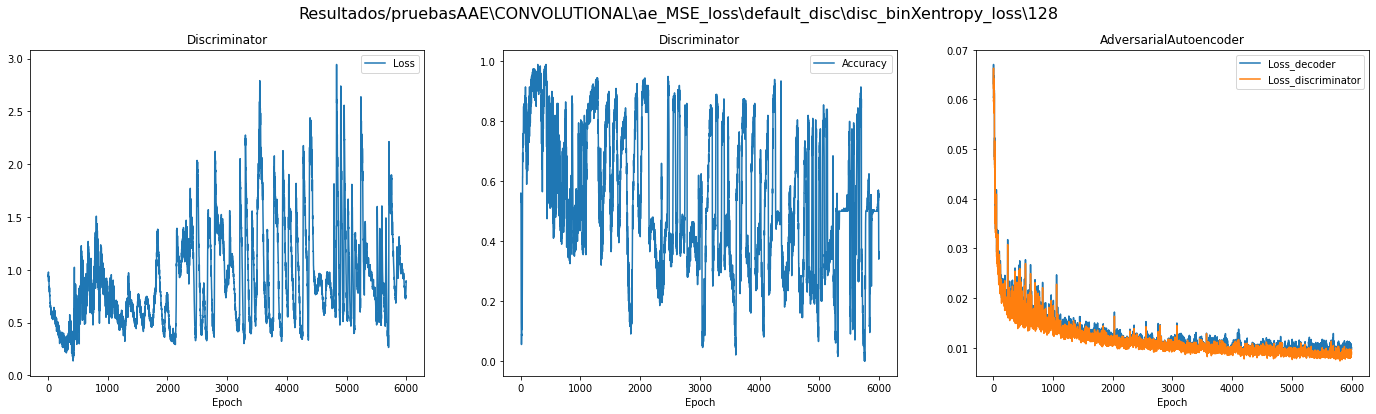

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


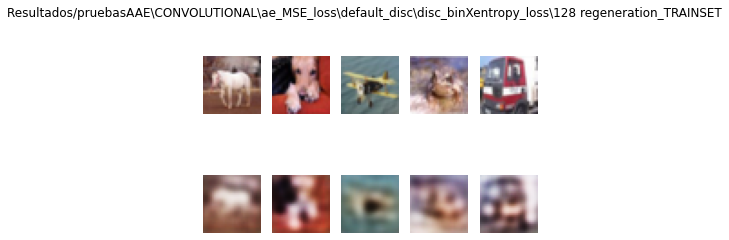

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


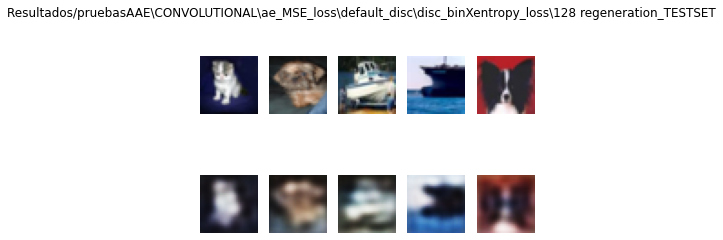

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):


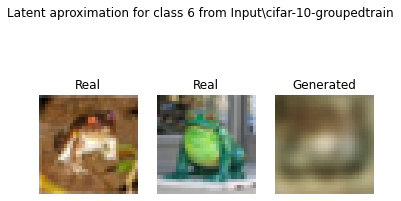

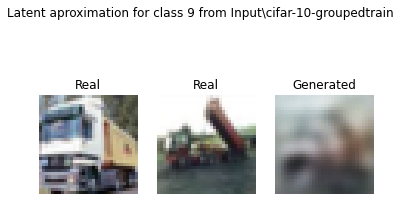

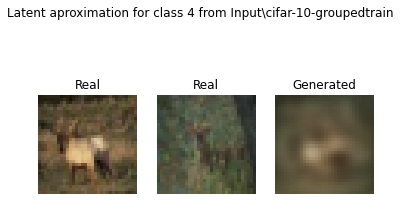

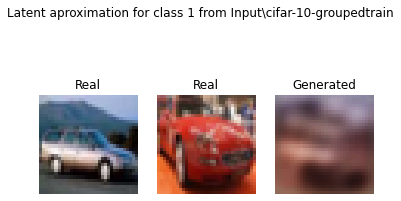

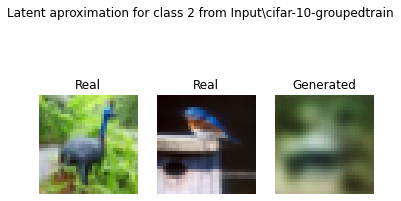

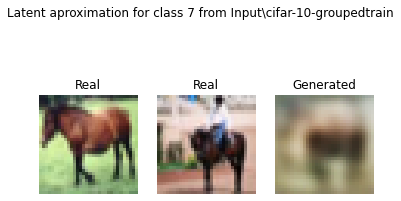

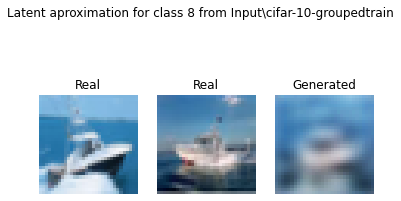

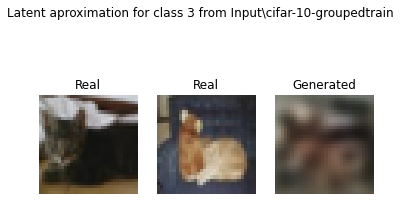

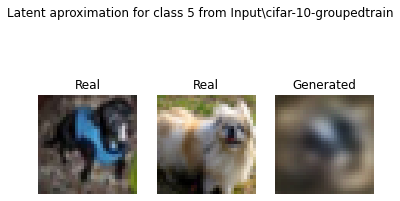

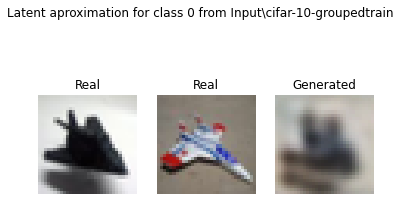

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):


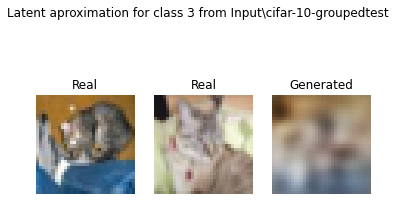

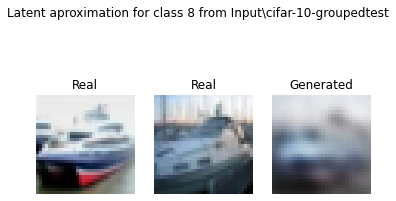

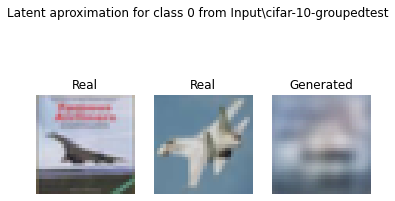

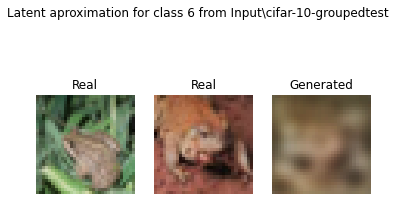

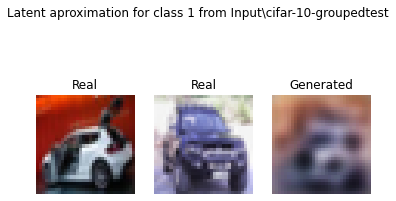

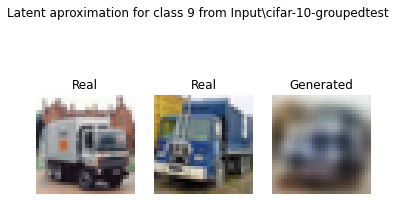

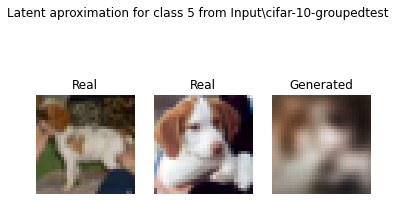

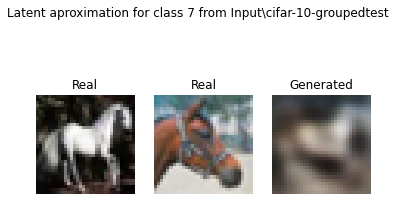

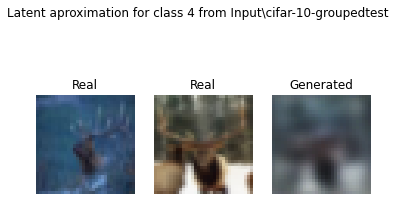

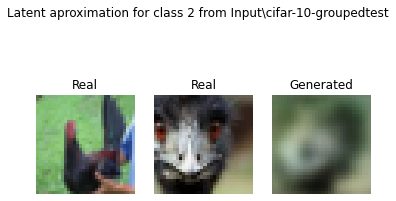

In [23]:
enc = (build_conv_encoder, "conv_enc")
dec = (build_conv_decoder,"conv_dec")
model_name = "CONVOLUTIONAL"

mainLoop(enc=enc, dec=dec, model_name=model_name)

### Entrenamiento de AAE Convolucional (con Transfer Encoder)

Layers for input 64 and output 1:
Layer 1: 16 neurons
Layer 2: 4 neurons
EPOCH 0
Epoch: 0 Step: 99 Disc: (loss = 0.566526, acc = 66.00%) AAE: (mse = 0.047683, b_ce = 0.046218)
Epoch: 0 Step: 199 Disc: (loss = 0.538752, acc = 71.50%) AAE: (mse = 0.038576, b_ce = 0.037145)
Epoch: 0 Step: 299 Disc: (loss = 0.545303, acc = 70.50%) AAE: (mse = 0.032483, b_ce = 0.031072)
Epoch: 0 Step: 399 Disc: (loss = 0.605732, acc = 67.00%) AAE: (mse = 0.033920, b_ce = 0.032738)
Epoch: 0 Step: 499 Disc: (loss = 0.574572, acc = 70.00%) AAE: (mse = 0.029974, b_ce = 0.028843)
EPOCH 1
Epoch: 1 Step: 99 Disc: (loss = 0.575058, acc = 70.50%) AAE: (mse = 0.027345, b_ce = 0.026308)
Epoch: 1 Step: 199 Disc: (loss = 0.607619, acc = 67.50%) AAE: (mse = 0.030604, b_ce = 0.029652)
Epoch: 1 Step: 299 Disc: (loss = 0.603795, acc = 69.00%) AAE: (mse = 0.026482, b_ce = 0.025579)
Epoch: 1 Step: 399 Disc: (loss = 0.630770, acc = 65.00%) AAE: (mse = 0.026952, b_ce = 0.026102)
Epoch: 1 Step: 499 Disc: (loss = 0.615007, acc = 

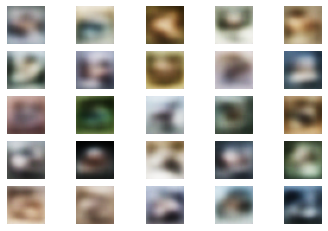

Historia del entrenamiento:


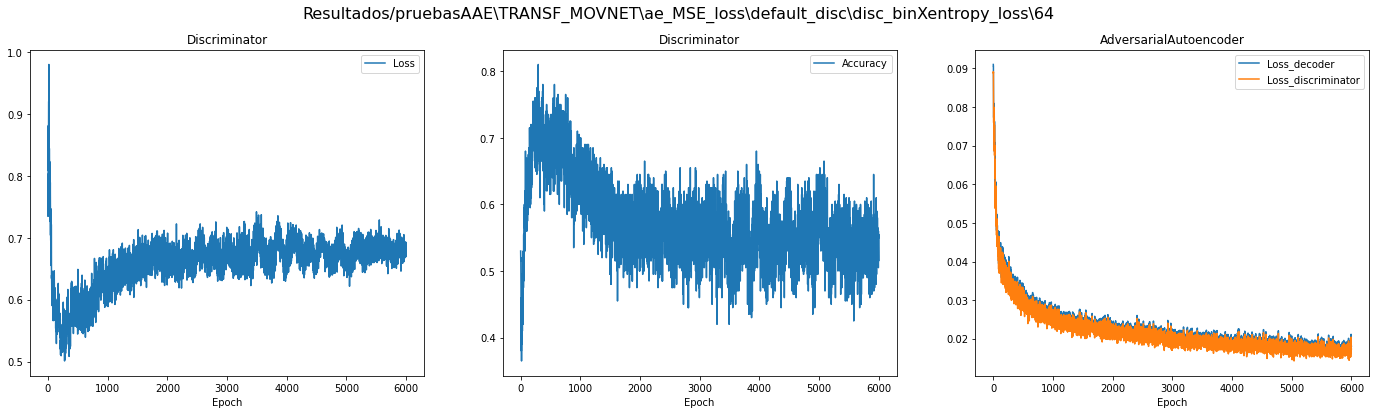

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


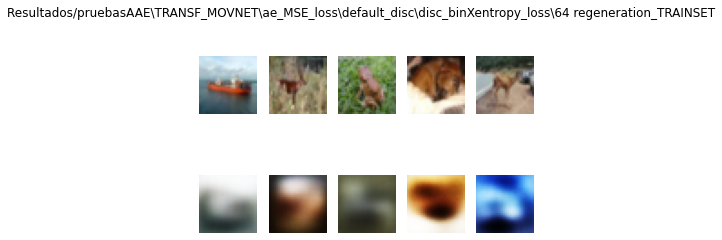

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


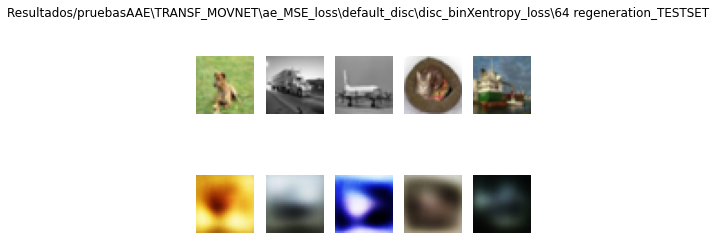

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):


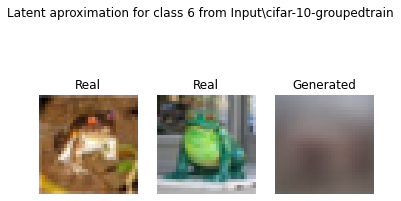

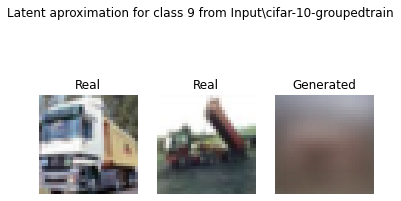

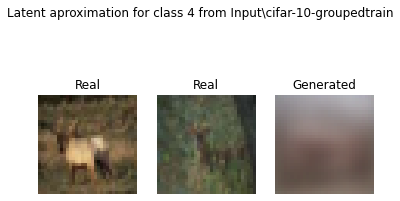

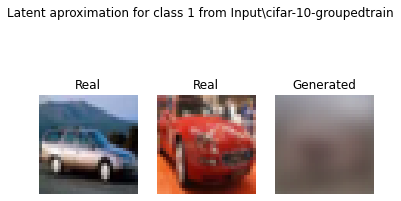

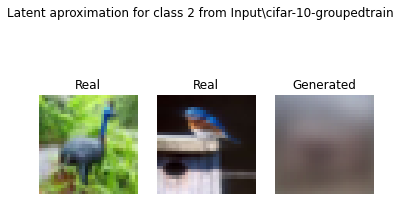

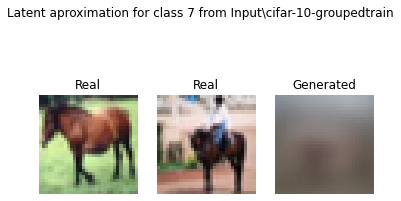

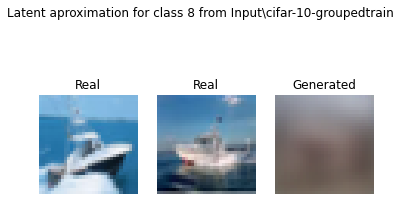

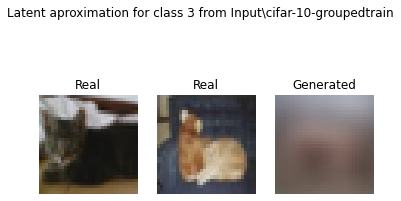

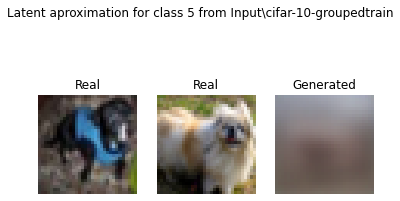

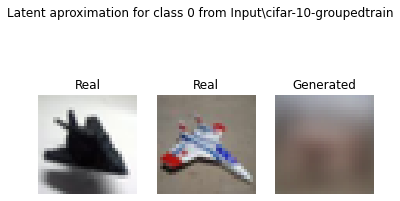

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):


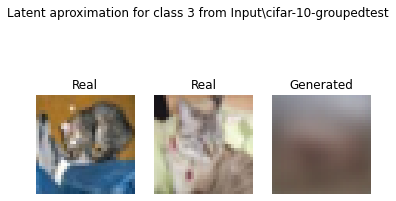

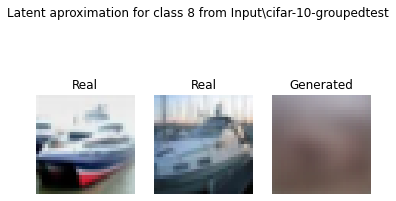

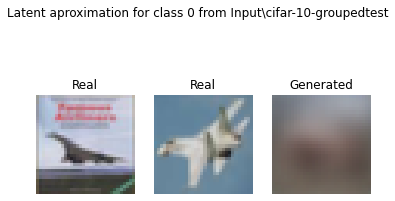

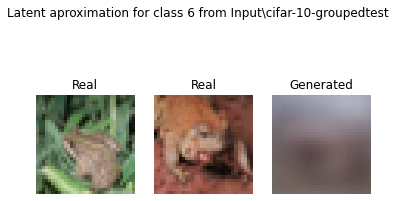

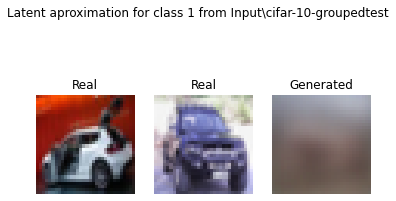

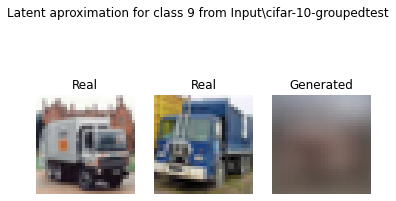

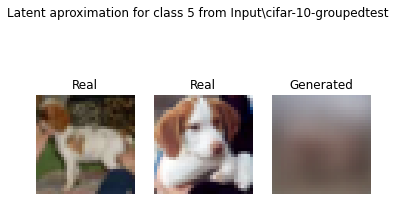

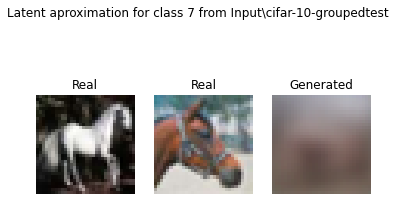

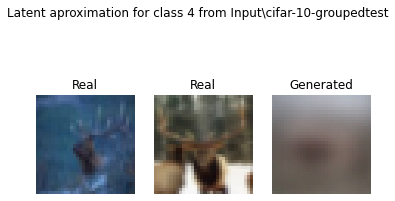

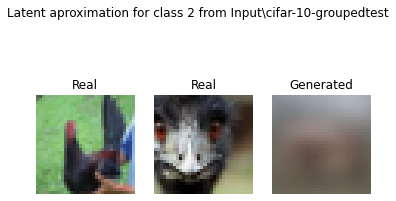

Layers for input 128 and output 1:
Layer 1: 25 neurons
Layer 2: 5 neurons
EPOCH 0
Epoch: 0 Step: 99 Disc: (loss = 0.622935, acc = 60.50%) AAE: (mse = 0.046184, b_ce = 0.044883)
Epoch: 0 Step: 199 Disc: (loss = 0.551236, acc = 70.00%) AAE: (mse = 0.039195, b_ce = 0.038026)
Epoch: 0 Step: 299 Disc: (loss = 0.519398, acc = 78.00%) AAE: (mse = 0.032892, b_ce = 0.031665)
Epoch: 0 Step: 399 Disc: (loss = 0.495349, acc = 79.00%) AAE: (mse = 0.034260, b_ce = 0.033075)
Epoch: 0 Step: 499 Disc: (loss = 0.535883, acc = 74.00%) AAE: (mse = 0.029408, b_ce = 0.028343)
EPOCH 1
Epoch: 1 Step: 99 Disc: (loss = 0.583909, acc = 69.50%) AAE: (mse = 0.027756, b_ce = 0.026761)
Epoch: 1 Step: 199 Disc: (loss = 0.521533, acc = 73.50%) AAE: (mse = 0.030381, b_ce = 0.029390)
Epoch: 1 Step: 299 Disc: (loss = 0.593208, acc = 69.00%) AAE: (mse = 0.026613, b_ce = 0.025629)
Epoch: 1 Step: 399 Disc: (loss = 0.612203, acc = 66.00%) AAE: (mse = 0.027415, b_ce = 0.026535)
Epoch: 1 Step: 499 Disc: (loss = 0.664316, acc =

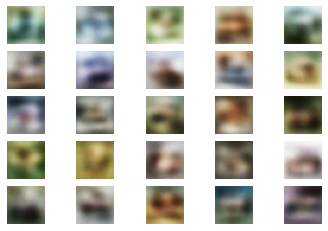

Historia del entrenamiento:


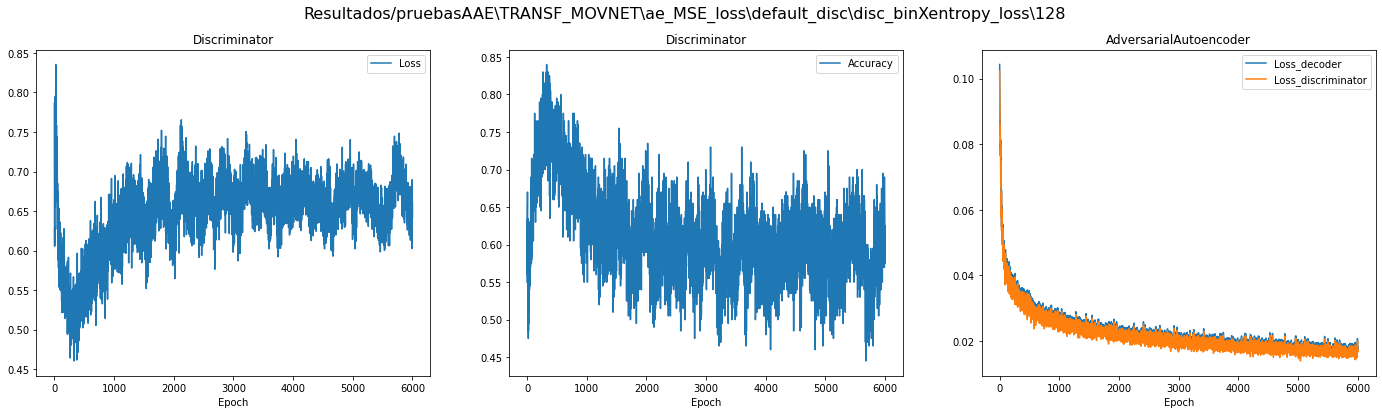

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


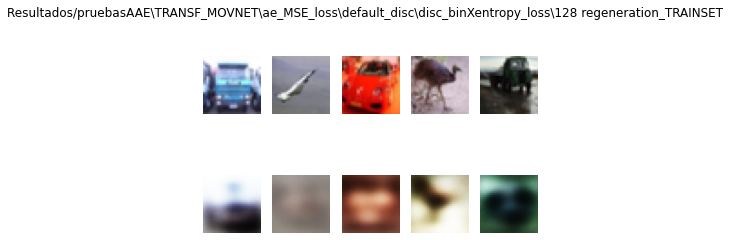

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


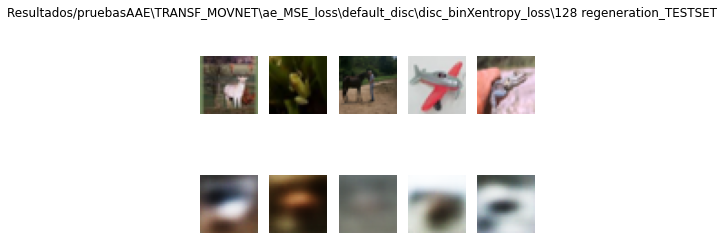

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):


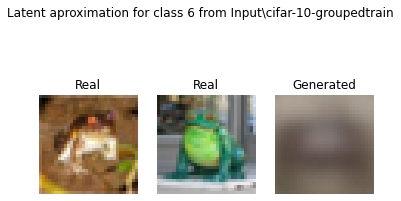

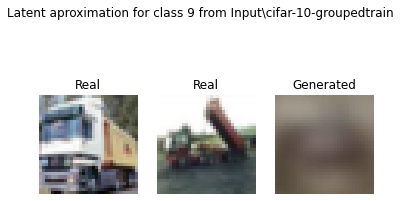

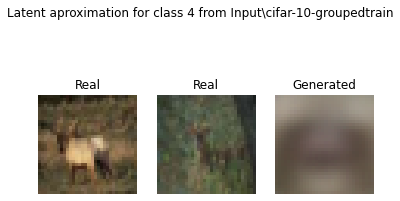

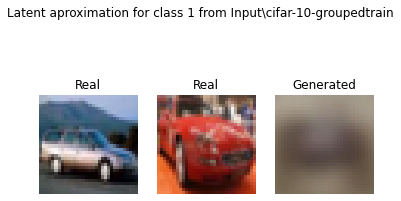

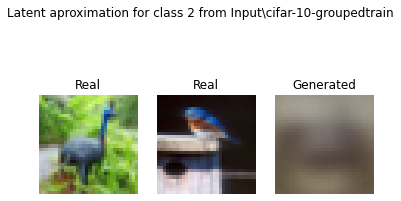

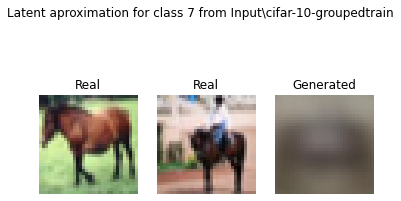

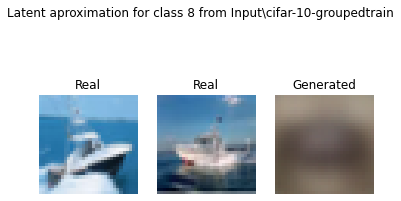

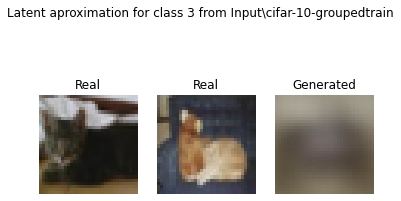

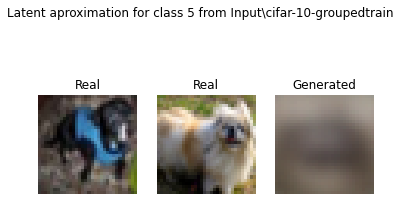

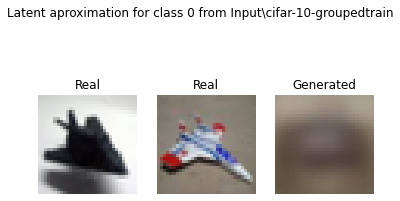

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):


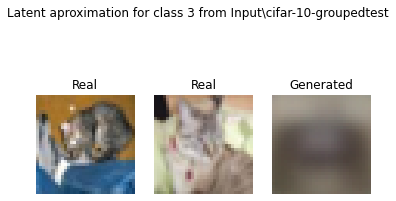

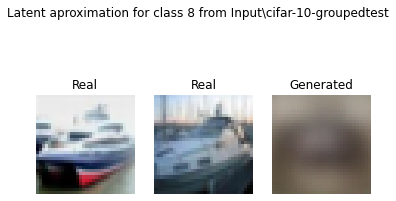

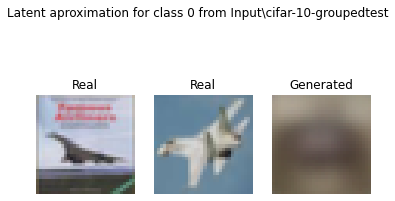

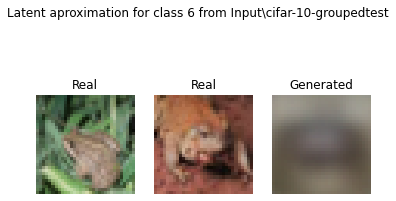

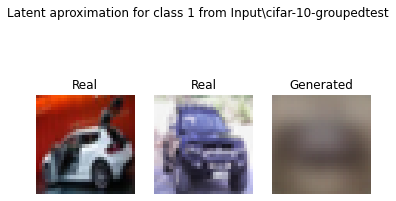

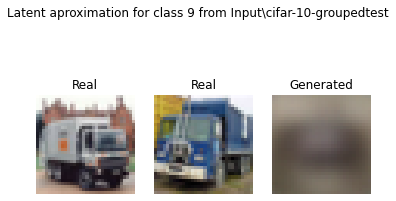

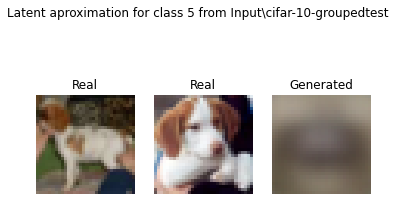

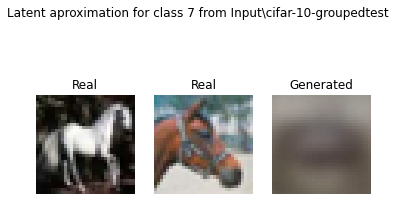

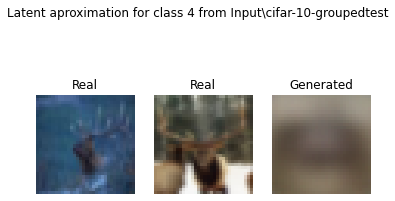

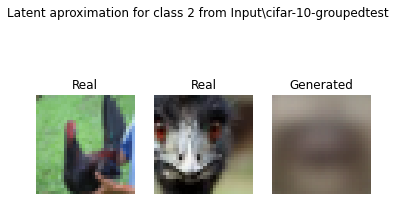

In [24]:
enc = (build_transf_encoder, "transf_enc")
dec = (build_conv_decoder,"conv_dec")
model_name = "TRANSF_MOVNET"

mainLoop(enc=enc, dec=dec, model_name=model_name)

epochs = 12
for enc in encoders:
    for dec in decoders:
        for ae_loss in ae_losses:
            for disc in discriminators:
                for disc_loss in disc_losses:
                    for dim_latente in dim_latente_cand:
                        ruta = _raiz+"\\"+enc[1]+"\\"+dec[1]+"\\"+ae_loss[1]+"\\"+disc[1]+"\\"+disc_loss[1]+"\\"+str(dim_latente)
                        if os.path.isfile(ruta+"/Modelos\\decoder.h5") or os.path.isfile(ruta+"/Modelos\\autoencoder.h5"):
                            print(ruta+" ya ha sido entrenada")
                            show_prevResults(ruta, epochs=epochs)
                            continue
                        mkfolders(ruta, True)
                        aae = assemble_AAE(dim_latente, img_shape, enc_model = enc[0], dec_model = dec[0], disc_model = disc[0], 
                                        ae_loss = ae_loss[0], disc_loss=disc_loss[0])
                        history = fit_AAE(dim_latente, aae, epochs=epochs, ruta = ruta)
                        print("Historia del entrenamiento:")
                        plot_history(history, ruta=ruta, title=ruta)
                        (encoder, decoder, _, autoencoder) = aae
                        print("Imagenes regeneradas desde el set de entrenamiento (arriba originales):")
                        sample_imgs(X_train, autoencoder, epoch=epochs, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TRAINSET")
                        print("Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):")
                        sample_imgs(sample_from, autoencoder, epoch=epochs, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TESTSET")
                        print("Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):")
                        exploraLatente(encoder, decoder, "Input\cifar-10-groupedtrain", ruta=ruta, nombre="GenFromLatentTRAINSET")
                        print("Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):")
                        exploraLatente(encoder, decoder, "Input\cifar-10-groupedtest", ruta=ruta, nombre="GenFromLatentTESTSET")
                        mkfolders(ruta+"/Modelos")
                        decoder.save(ruta+"/Modelos\\decoder.h5")
                        #autoencoder.save(ruta+"/Modelos\\autoencoder.h5")
